# INTRO 👋

2023 marked the rise of the GenAI buzz, and many companies worldwide are working hard to take advantage of its capabilities to solve advanced problems. The [Malawi Public Health Systems LLM Challenge](https://zindi.africa/competitions/malawi-public-health-systems-llm-challenge) is one of the first GenAI competitions on Zindi. If you are new to Generative AI or perhaps just trying to get a sense of how to solve this challenge, then this notebook can get you started. This notebook is focused on RAG (Retrieval Augmented Generation), which leverages existing LLMs to perform Q&A using a provided context. 

# The Data 📊

When examining the data tab on Zindi, we find three files. Let's break it down:

- **Train.csv:** This file contains 748 rows × 6 columns, which can be used to train a model.
- **Test.csv:** This file contains 499 rows, which are the test questions.
- **SampleSubmission.csv:** This CSV file is the sample submission format that Zindi expects.

### Extras 📁:
- **MWTGBookletsExcel** This folder contains six Excel spreadsheets. In this competition, I renamed the spreadsheets as the original names were too long. I've manually shortened the names to keep things simple. Please ensure you do this via code if you'd like to do the same.

Original Filenames:

1. TG Booklet 1 Introduction Module Booklet 1TG_final_04112021.xlsx
2. TG Booklet 2 Sections 1,2,3_final_04112021.xlsx
3. TG Booklet 3 Section 4,5,6,7_final_04112021.xlsx
4. TG Booklet 4 Sections 8, 9_final_04112021.xlsx
5. TG Booklet 5 Section 10_final_04112021.xlsx
6. TG Booklet 6_Section 11_final_04112021.xlsx

Renamed:

1. TG Booklet 1.xlsx
2. TG Booklet 2.xlsx
3. TG Booklet 3.xlsx
4. TG Booklet 4.xlsx
5. TG Booklet 5.xlsx
6. TG Booklet 6.xlsx


## Requirements 🛠️

Just a basic setup: please use a GPU-enabled setup for your inference, but don't spend the whole day on it. I'm using Kaggle since they offer free GPUs; you can also use any other free platform you like... I guess.. 😬. Of course, if you don't have access to GPUs for some reason, you can also run it on CPUs.

###### Last Thing Before You Start! 🚀

Read the description before you start coding, so you can have some insight into the challenge. This notebook does not cover training/fine-tuning a model. Below is a simple workflow.

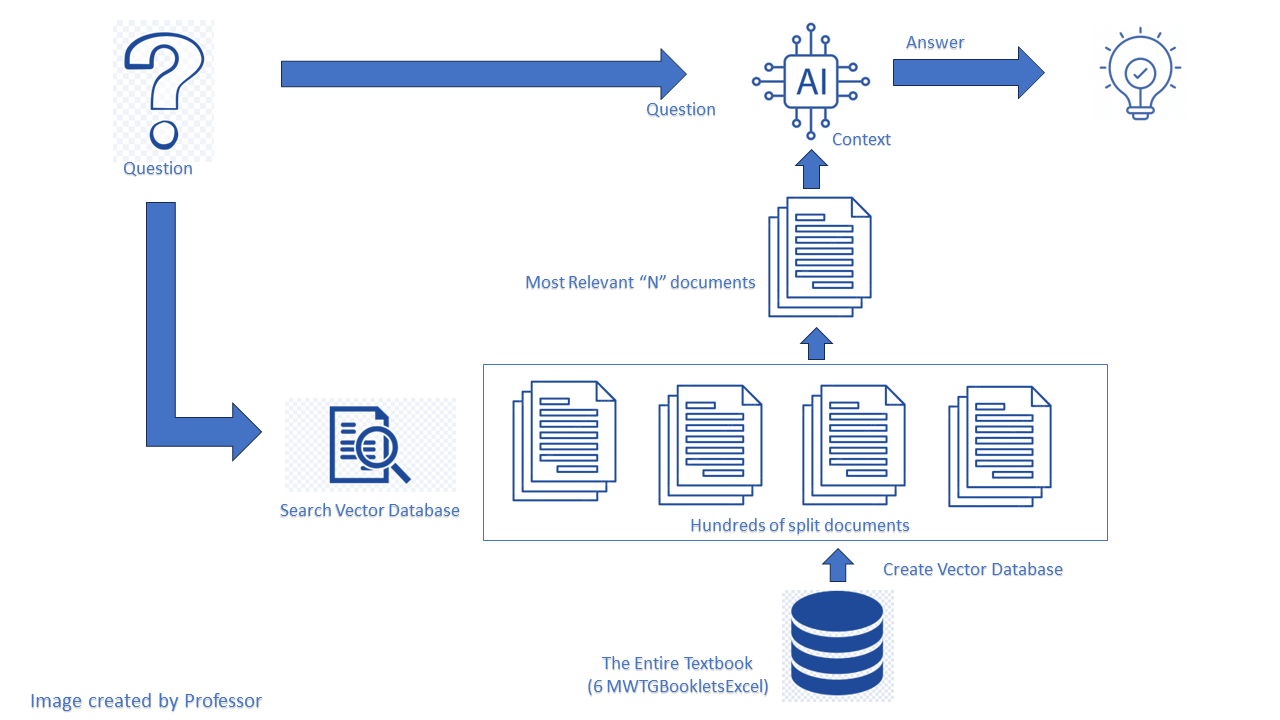

## Setting up Huggingface. 🤖

There are several pretrained models for text-to-text generation. For this demo, we'll be using the Llama-2-70b-chat-hf. It is available on the hub and is open source, however it is gated. This means you will have to request access to the model via the hub. This is due to the safety and ethics principles Meta aims to uphold. It's still completely free and open source. Note that request approvals may take up to a few hours to a few days. If you can't wait, feel free to switch to other models that are not gated. ⏳


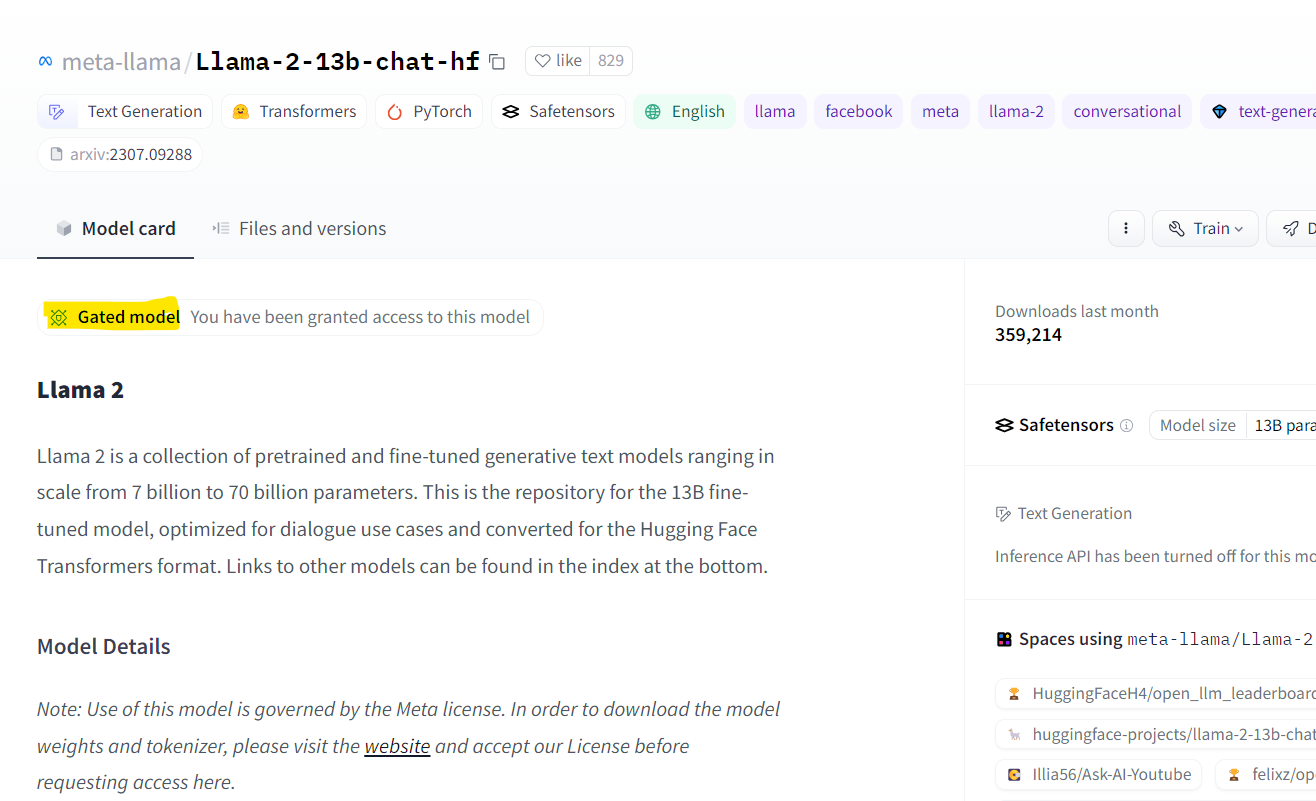

Replace `YOUR_HF_TOKEN` 🔑 with your Huggingface token. Hugging Face needs to be sure you have access to the model.

In [19]:
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token ('YOUR_HF_TOKEN')"

## Installing Libraries. 

##### Langchain

The major library we'll be using among others is Langchain. LangChain is a framework for developing applications powered by language models. It enables applications that:

1. Are context-aware: connect a language model to sources of context (prompt instructions, few shot examples, content to ground its response in, etc.) 🧠
2. Reason: rely on a language model to reason (about how to answer based on provided context, what actions to take, etc.) 🤔

Read more about LangChain at [LangChain Documentation](https://python.langchain.com/docs/get_started/introduction) 📚


##### chromadb

Chroma is a database for building AI applications with embeddings. It comes with everything you need to get started built in, and runs on your machine locally. According to their website, a hosted version is coming soon! Read more about ChromaDB here at [ChromaDB Documentation](https://docs.trychroma.com/getting-started) 📦

###### bitsandbytes

The bitsandbytes library is a lightweight Python wrapper around CUDA custom functions, particularly 8-bit optimizers, matrix multiplication (`LLM.int8()`), and 8 + 4-bit quantization functions. Learn more about bitsandbytes [here](https://huggingface.co/docs/bitsandbytes/main/en/index) 🧊🔢

In [1]:
import pandas as pd
import numpy as np

In [3]:
!pip install langchain_community -qq #The langchain community builds tools that are stored here

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.1.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2024.1.0 which is incompatible.
dask-cuda 23.8.0 require

In [4]:
!pip install -U langchain -qq

In [5]:
!pip install unstructured -qq #This will be used to load in our excel sheets (The textbooks)

In [6]:
%%capture

!pip install transformers==4.33.0 accelerate==0.22.0 einops==0.6.1 xformers==0.0.21 \
bitsandbytes==0.41.1 sentence_transformers==2.2.2 chromadb==0.4.12

## Taking a Look at the Data 👀

The Train and Test files come as a CSV file. For convenience and to check out the data, we can load it into a dataframe using pandas. 🐼

If you are getting an error, it means you haven't uploaded the dataset into Kaggle, or your path is incorrect. 🚨


###### more details

- **ID:** The question ID
- **Question Text:** Essentially the text of the questions.
- **Question Answer:** The Answer to the Question Text
- **Reference Document:** This is where the Answer is in the textbook (Remember there are 6 excel sheets where the textbooks are)
- **Paragraph(s) Number:** This is Paragraph in the Reference Document where the answers are
- **Keywords:** The contextual Keywords 📝


In [7]:
path = "/kaggle/input/malawi-public-health-dataset/strengthening-health-systems-llm-challenge-for-integrated-disease-surveillance-and-response-in-malawi20240125-12750-1x85c8a"
train = pd.read_csv(f"{path}/Train.csv")
train

,ID,Question Text,Question Answer,Reference Document,Paragraph(s) Number,Keywords
0,Q829,Compare the laboratory confirmation methods fo...,Chikungunya is confirmed using serological tes...,TG Booklet 6,"154, 166",Laboratory Confirmation For Chikungunya Vs. Di...
1,Q721,When should specimens be collected for Anthrax...,Specimens should be collected during the vesic...,TG Booklet 6,140,"Anthrax Specimen Collection: Timing, Preparati..."
2,Q464,Which key information should be recorded durin...,"During a register review, key information abou...",TG Booklet 3,439-440,"Register Review, Key Information, Suspected Ca..."
3,Q449,Why is the District log of suspected outbreaks...,The log includes information about response ac...,TG Booklet 3,412,"District Log, Response Activities, Steps Taken..."
4,Q6,What do Community based surveillance strategie...,Community-based surveillance strategies focus ...,TG Booklet 1,86,"Community-based Surveillance Strategies, Ident..."
...,...,...,...,...,...,...
743,Q413,Which section of the guidelines provides a des...,Section 11.0 of these 3rd Edition Malawi IDSR ...,TG Booklet 3,376,"Control Measures Description, Priority Disease..."
744,Q626,"Does MEF stand for an abbreviation in the TG, ...",Medical Teams International,TG Booklet 6,106,Medical Teams International
745,Q1141,In what ways do the verification and documenta...,"In emergency contexts, verification and docume...",TG Booklet 5,105-106,"Verification, Documentation, Early Warning, Em..."
746,Q331,What role does the examination of burial cerem...,Examining burial ceremonies helps identify pot...,TG Booklet 3,287,"Burial Ceremonies Examination, Exposure, Trans..."


In [8]:
test = pd.read_csv(f"{path}/Test.csv")
test

,ID,Question Text
0,Q4,"What is the definition of ""unusual event"""
1,Q5,What is Community Based Surveillance (CBS)?
2,Q9,What kind of training should members of VHC re...
3,Q10,What is indicator based surveillance (IBS)?
4,Q13,What is Case based surveillance?
...,...,...
494,Q1229,Where should completeness be evaluated in the ...
495,Q1230,Which dimensions of completeness are crucial i...
496,Q1236,How can the completeness of case reporting be ...
497,Q1239,Where should completeness and timeliness of re...


###### Submission Format 

Everything has to be passed as a separate index 📝


In [9]:
ss = pd.read_csv(f"{path}/SampleSubmission.csv")
ss

,ID,Target
0,Q1000_keywords,
1,Q1000_paragraph(s)_number,
2,Q1000_question_answer,
3,Q1000_reference_document,
4,Q1002_keywords,
...,...,...
1991,Q999_reference_document,
1992,Q9_keywords,
1993,Q9_paragraph(s)_number,
1994,Q9_question_answer,


######  Make the necessary imports 📚


In [10]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
#import chromadb
#from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA,ConversationalRetrievalChain
from langchain.vectorstores import Chroma

## Large Language  (LLMs) 

LLMs, which stand for Large Language Models, are foundational language models that are very large as the name implies. They can understand and generate human language text. 

They are trained by analyzing massive datasets of text and learning the statistical relationships between words and phrases. This allows them to perform a variety of tasks, such as:

- Answering your questions in an informative way, even if they are open-ended, challenging, or strange.
- Generating different creative text formats, like poems, code, scripts, musical pieces, email, letters, etc.
- Translating languages
- Writing different kinds of creative content
- Summarizing factual topics

In this tutorial, we're focused on using them for question answering. There are a couple of Open Source LLMs, but for this tutorial, we're using Meta's Llama model. There are various sizes on the hub, but here we'll use the "Llama-2-13b-chat-hf" 🦙


Let's see what a sample question looks like from the test set. 🕵️‍♂️

In [11]:
question = test["Question Text"][0]
question

'What is the definition of "unusual event"'

###### Use Bits and Bytes library to create a config.

LLMs can be very large, but a lot of awesome work has been done in loading large language models on low resource. I'll encourage you to read papers on QLORA, PEFT, GPTQ, etc. Very interesting ideas have been created thanks to the research community. We'll load this large model using the Normal Float 4 precision. 🛠️🔢

In [12]:
model_id = 'meta-llama/Llama-2-13b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

###### Using Transformers to load in the model

The transformers library is still one of the best resources to load transformer-based models. Everything is automatically set up; we pass in the model configuration and the configuration for Bits and Bytes. 🤖📦

In [ ]:
time_1 = time()
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
)
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
time_2 = time()
print(f"Prepare model, tokenizer: {round(time_2-time_1, 3)} sec.")

###### Transformers Pipeline 🚀

In [14]:
time_1 = time()
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        device_map="auto",)
time_2 = time()
print(f"Prepare pipeline: {round(time_2-time_1, 3)} sec.")

Prepare pipeline: 2.02 sec.


### A Quick Test Run

So let's do a quick test run of the pipeline to see it work 🏃‍♂️💨

In [15]:
def test_model(tokenizer, pipeline, prompt_to_test):
    """
    Perform a query
    print the result
    Args:
        tokenizer: the tokenizer
        pipeline: the pipeline
        prompt_to_test: the prompt
    Returns
        None
    """
    # adapted from https://huggingface.co/blog/llama2#using-transformers
    time_1 = time()
    sequences = pipeline(
        prompt_to_test,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)
    time_2 = time()
    print(f"Test inference: {round(time_2-time_1, 3)} sec.")
    for seq in sequences:
        print(f"Result: {seq['generated_text']}")

Here, you see that even on GPU, it takes roughly 25 seconds to answer the question "what is the definition of unusual event". The model also answers the question in relation to **Nuclear power plant** as shown below instead of **Public Health** ⏱️🚀

In [16]:
print(question)
test_model(tokenizer,
           query_pipeline,
           question)

What is the definition of "unusual event"
Test inference: 24.288 sec.
Result: What is the definition of "unusual event" in the context of nuclear power plants?

Answer: In the context of nuclear power plants, an "unusual event" is defined as any situation or condition that is not normal or expected, and that has the potential to adversely affect the safe operation of the plant. This can include events such as equipment failures, power fluctuations, or changes in plant conditions that are not within the normal operating parameters.

The definition of an unusual event may vary depending on the specific plant and the regulatory body overseeing its operation. However, in general, an unusual event is considered to be any situation that is not routine or expected, and that has the potential to impact the safe operation of the plant.

Examples of unusual events in a nuclear power plant might include:

* A sudden loss of power to a critical system
* An unexpected increase in radiation levels i

###### Testing the Model with HuggingFace Pipeline Class 

In [17]:
llm = HuggingFacePipeline(pipeline=query_pipeline)#, model_kwargs={"max_length":512})
# checking again that everything is working fine
llm(prompt=question)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


' for the purpose of this rule?\n\nA. Any situation that is not part of the normal or expected operations of the facility.\n\nB. Any situation that could potentially cause harm to people or the environment.\n\nC. Any situation that is not specifically addressed in the facility\'s emergency plan.\n\nD. Any situation that is not within the facility\'s control.\n\nCorrect answer: B. Any situation that could potentially cause harm to people or the environment.\n\nExplanation: The definition of "unusual event" in this rule is any situation that could potentially cause harm to people or the environment. This definition is intended to capture any event or situation that is not part of the normal or expected operations of the facility, and that could potentially have a significant impact on the safety of the facility, its employees, or the surrounding community.\n\n2. Which of the following is NOT a requirement for an effective emergency response plan?\n\nA. A clear chain of command and commun

## RAG 📚

Retrieval Augmented Generation, or RAG, is a technique used to improve the accuracy and reliability of Large Language Models (LLMs). As you know, LLMs are trained on massive amounts of text data, but they can still struggle with factual consistency and sometimes generate incorrect or misleading information. RAG helps address this by incorporating external/relevant knowledge sources into the generation process.

Here's how it works:

- Retrieval: When you ask an LLM a question or give it a prompt, RAG first retrieves relevant information from the Public Health Vector Database created with the 6 textbooks. 📖

- Augmentation: This retrieved information is then combined with the original prompt to provide the LLM with additional context and factual grounding. 

- Generation: Finally, the LLM uses this augmented prompt to generate its response. This response would be more accurate and reliable because it's based on both the LLM's internal knowledge and the retrieved factual information. 🎯

### Questions ❓

- Why not pass the entire textbook to the LLM? The entire textbook is a lot. LLMs have a "context length" which is the maximum amount of input text they can take in and understand. Also, the more text, the more compute required. It makes more sense to first look for the relevant parts then pass it to the LLM. 🤔


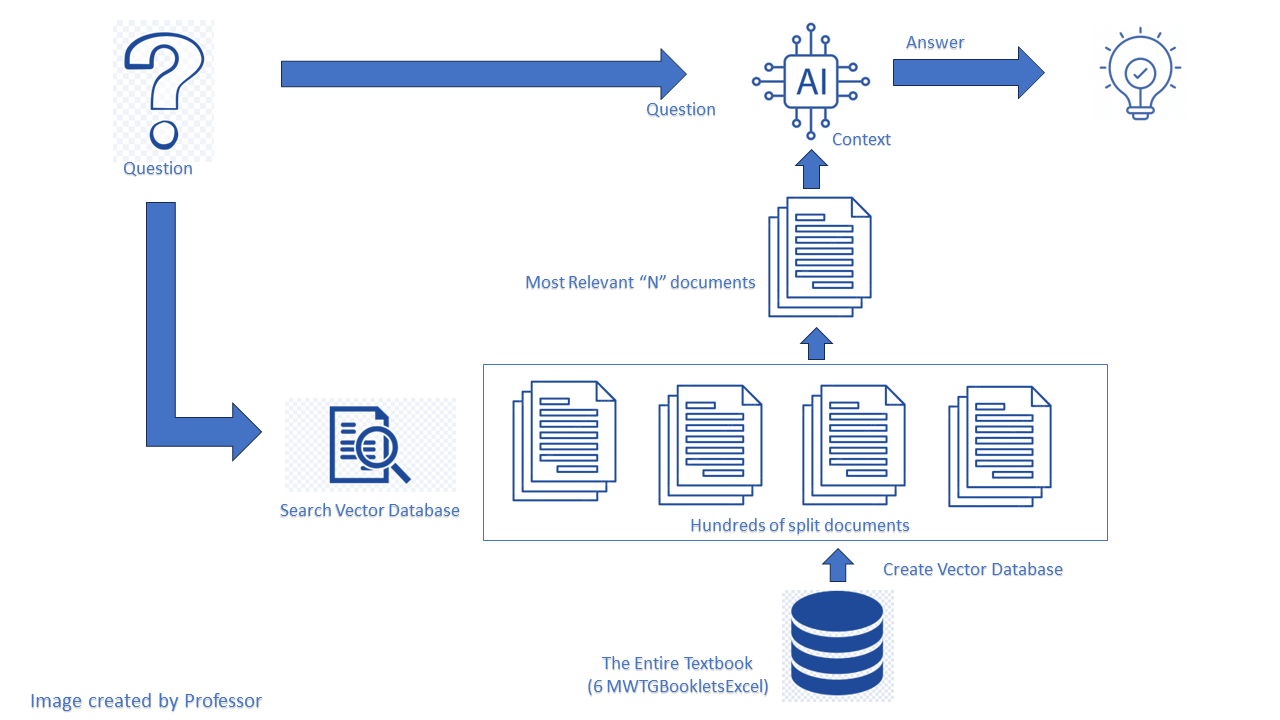

###### Load in the Textbooks 📚


In [18]:
import os
books_path = "/kaggle/input/malawi-public-health-dataset/strengthening-health-systems-llm-challenge-for-integrated-disease-surveillance-and-response-in-malawi20240125-12750-1x85c8a/MWTGBookletsExcel"
booklets = os.listdir(books_path)

There are several dataloaders that have been created by the LangChain community. One of such is the ```UnstructuredExcelLoader```, which loads in an Excel spreadsheet as an unstructured data format. 📊📄

In [19]:
from langchain_community.document_loaders import UnstructuredExcelLoader

###### Load all the 6 textbooks

Here we load it and extend it in a list called docs 📚


In [20]:
loaders = [UnstructuredExcelLoader(f"{books_path}/{i}") for i in booklets]
docs = []
for loader in loaders:
    docs.extend(loader.load())

###### Splitting the data.

LangChain has several splitting methods, a basic one is the "RecursiveCharacterTextSplitter" which splits the data (text) by chunks of n characters, and includes an overlap of k characters called the chunk overlap. 📝🔀


In [21]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(docs)

###### Tokenizing the data

NLP took a huge leap during the discovery of embeddings. Sentence Embeddings or Sentence Vectors are numeric vector inputs that represent a sentence in a lower-dimensional space. It allows sentences with similar meanings to have a similar representation. You can read more about embeddings [here](https://huggingface.co/blog/getting-started-with-embeddings)

For this tutorial, we'll be making use of `sentence-transformers/all-mpnet-base-v2`. It is a model that maps sentences & paragraphs to a 768-dimensional dense vector space and can be used for tasks like clustering or semantic search. It's available and open source on the Hub. 🌐🔠


In [22]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

##### Vector Databases

Vector databases provide the ability to store and retrieve vectors as high-dimensional points. They add additional capabilities for efficient and fast lookup of nearest-neighbors in the N-dimensional space. 🗄️🔍

In the code below, we create a vector database with Chroma. We then pass in all the splits (chunks of the entire textbook) and the embedding model to convert them into embeddings. 💡📚


In [23]:
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

###### Langchain's Retrieval QA

LangChain has the ability to create or arrange chains, one of such popular chains is the RetrievalQA which can take in the retriever (the function that retrieves the relevant chunk) and the LLM (that will answer the question).

For the Retriever, you'll find that I've set k=3. This is the maximum number of splits I want returned from the vector database. In other words, the vector database finds the correct split and gives us the best 3 to work with. We then combine this best 3 chunks with the question (prompt) and get a RAG-based answer. 🔄🔍

In [24]:
retriever = vectordb.as_retriever(k=3)

qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True,
)


###### Using the RAG for the Test Set

In [25]:
def test_rag(qa, query):
    #print(f"Query: {query}\n")
    time_1 = time()
    result = qa.run(query)
    time_2 = time()
    time_taken = round(time_2-time_1, 3)
    #print(f"Inference time: {round(time_2-time_1, 3)} sec.")
    #print("\nResult: ", result)
    return result,time_taken

I wanted to keep track of some data aside from the answer:

1. One that is important is the source, i.e., which of the Excel spreadsheets did it find the relevant information?
2. The other one is the time it took to answer the question through the RAG.

As you'll remember, the sample submission requires us to submit the "Answer", "Textbook Source", "Paragraph", and even "Keywords". For now, we'll deal with the "Answer and Textbook Source" and later on use simpler methods to extract the relevant paragraph and the Keywords. 📊⏱️


In [26]:
from tqdm import tqdm

In [31]:
times = []
results = []
sources = []
for question in tqdm(test["Question Text"]):
    try:
        result,time_taken = test_rag(qa, question)
        docs = vectordb.similarity_search(result)
        source = docs[0].metadata['source'].split("/")[-1]

        times.append(time_taken)
        results.append(result)
        sources.append(source)
    except:
        
        times.append("Error")
        results.append("Error")
        sources.append("Error")   

  0%|          | 0/499 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...


  0%|          | 1/499 [00:27<3:48:59, 27.59s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  0%|          | 2/499 [00:44<2:57:32, 21.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  1%|          | 3/499 [00:54<2:14:56, 16.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  1%|          | 4/499 [01:05<1:56:12, 14.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  1%|          | 5/499 [01:12<1:34:36, 11.49s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  1%|          | 6/499 [01:55<3:01:45, 22.12s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  1%|▏         | 7/499 [02:11<2:46:55, 20.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


  2%|▏         | 8/499 [02:19<2:14:05, 16.39s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 9/499 [02:41<2:27:06, 18.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 10/499 [02:54<2:14:58, 16.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 11/499 [03:08<2:07:27, 15.67s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 12/499 [03:19<1:56:07, 14.31s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  3%|▎         | 13/499 [03:30<1:46:41, 13.17s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  3%|▎         | 14/499 [03:50<2:04:05, 15.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  3%|▎         | 15/499 [03:57<1:43:20, 12.81s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  3%|▎         | 16/499 [04:04<1:28:48, 11.03s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  3%|▎         | 17/499 [04:31<2:06:37, 15.76s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  4%|▎         | 18/499 [04:41<1:53:03, 14.10s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  4%|▍         | 19/499 [04:54<1:50:55, 13.87s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  4%|▍         | 20/499 [05:05<1:44:10, 13.05s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  4%|▍         | 21/499 [05:18<1:42:24, 12.85s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  4%|▍         | 22/499 [05:26<1:31:40, 11.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▍         | 23/499 [05:35<1:24:06, 10.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▍         | 24/499 [05:44<1:21:20, 10.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▌         | 25/499 [05:52<1:16:10,  9.64s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▌         | 26/499 [06:03<1:18:32,  9.96s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▌         | 27/499 [06:15<1:22:26, 10.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▌         | 28/499 [06:35<1:45:31, 13.44s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▌         | 29/499 [06:49<1:46:20, 13.57s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▌         | 30/499 [07:09<2:00:52, 15.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▌         | 31/499 [07:20<1:51:24, 14.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▋         | 32/499 [07:30<1:40:37, 12.93s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 33/499 [07:42<1:38:39, 12.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 34/499 [15:01<18:09:40, 140.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 35/499 [15:15<13:12:41, 102.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 36/499 [15:28<9:43:41, 75.64s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  7%|▋         | 37/499 [15:41<7:17:49, 56.86s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  8%|▊         | 38/499 [15:54<5:36:50, 43.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  8%|▊         | 39/499 [16:03<4:14:34, 33.21s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  8%|▊         | 40/499 [16:13<3:20:35, 26.22s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  8%|▊         | 41/499 [16:25<2:47:27, 21.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  8%|▊         | 42/499 [16:39<2:28:46, 19.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  9%|▊         | 43/499 [16:48<2:05:17, 16.49s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  9%|▉         | 44/499 [17:12<2:21:20, 18.64s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  9%|▉         | 45/499 [17:26<2:11:32, 17.39s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  9%|▉         | 46/499 [17:35<1:52:19, 14.88s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  9%|▉         | 47/499 [17:50<1:53:15, 15.03s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 10%|▉         | 48/499 [18:02<1:45:14, 14.00s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 10%|▉         | 49/499 [18:20<1:54:28, 15.26s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 10%|█         | 50/499 [18:36<1:56:19, 15.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 10%|█         | 51/499 [18:47<1:45:21, 14.11s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 10%|█         | 52/499 [18:56<1:32:36, 12.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 11%|█         | 53/499 [19:14<1:45:18, 14.17s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 11%|█         | 54/499 [19:34<1:56:58, 15.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 11%|█         | 55/499 [19:56<2:10:32, 17.64s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 11%|█         | 56/499 [20:03<1:46:41, 14.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 11%|█▏        | 57/499 [20:24<2:03:02, 16.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 12%|█▏        | 58/499 [26:20<14:29:33, 118.31s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 12%|█▏        | 59/499 [26:28<10:25:50, 85.34s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 12%|█▏        | 60/499 [26:55<8:15:47, 67.76s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 12%|█▏        | 61/499 [27:24<6:50:27, 56.23s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 12%|█▏        | 62/499 [27:58<5:59:20, 49.34s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 13%|█▎        | 63/499 [28:24<5:08:05, 42.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 13%|█▎        | 64/499 [28:36<4:01:35, 33.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 13%|█▎        | 65/499 [28:59<3:39:14, 30.31s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 13%|█▎        | 66/499 [29:10<2:56:52, 24.51s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 13%|█▎        | 67/499 [29:25<2:35:59, 21.67s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▎        | 68/499 [29:36<2:12:30, 18.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▍        | 69/499 [29:54<2:11:28, 18.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▍        | 70/499 [30:12<2:10:35, 18.27s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▍        | 71/499 [30:25<1:58:02, 16.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▍        | 72/499 [30:35<1:43:50, 14.59s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 15%|█▍        | 73/499 [30:46<1:36:03, 13.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 15%|█▍        | 74/499 [31:04<1:46:11, 14.99s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 15%|█▌        | 75/499 [37:44<15:20:57, 130.33s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 15%|█▌        | 76/499 [44:16<24:33:24, 208.99s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 15%|█▌        | 77/499 [44:33<17:43:28, 151.21s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 16%|█▌        | 78/499 [44:51<13:01:29, 111.38s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 16%|█▌        | 79/499 [45:11<9:47:02, 83.86s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 16%|█▌        | 80/499 [45:22<7:14:01, 62.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 16%|█▌        | 81/499 [45:37<5:34:00, 47.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 16%|█▋        | 82/499 [45:46<4:12:26, 36.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 83/499 [46:00<3:25:13, 29.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 84/499 [46:12<2:48:30, 24.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 85/499 [46:19<2:11:18, 19.03s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 86/499 [46:36<2:07:42, 18.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 87/499 [47:08<2:34:15, 22.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 88/499 [47:34<2:42:06, 23.66s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 89/499 [47:50<2:24:27, 21.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 90/499 [54:51<16:02:04, 141.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 91/499 [55:05<11:41:41, 103.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 92/499 [55:15<8:29:32, 75.12s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▊        | 93/499 [55:36<6:38:19, 58.87s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▉        | 94/499 [55:47<4:59:38, 44.39s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▉        | 95/499 [56:21<4:39:32, 41.52s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▉        | 96/499 [56:36<3:44:58, 33.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▉        | 97/499 [58:59<7:24:13, 66.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 20%|█▉        | 98/499 [59:11<5:34:02, 49.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 20%|█▉        | 99/499 [59:31<4:33:43, 41.06s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 20%|██        | 100/499 [59:47<3:42:29, 33.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 20%|██        | 101/499 [1:00:00<3:00:22, 27.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 20%|██        | 102/499 [1:02:01<6:06:12, 55.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 21%|██        | 103/499 [1:02:18<4:50:29, 44.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 21%|██        | 104/499 [1:02:36<3:58:06, 36.17s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 21%|██        | 105/499 [1:02:50<3:13:29, 29.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 21%|██        | 106/499 [1:03:11<2:57:05, 27.04s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 21%|██▏       | 107/499 [1:03:33<2:46:28, 25.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 22%|██▏       | 108/499 [1:04:08<3:04:09, 28.26s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 22%|██▏       | 109/499 [1:04:23<2:38:04, 24.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 22%|██▏       | 110/499 [1:04:35<2:13:14, 20.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 22%|██▏       | 111/499 [1:10:04<12:11:45, 113.16s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 22%|██▏       | 112/499 [1:10:17<8:56:55, 83.24s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 23%|██▎       | 113/499 [1:10:57<7:30:23, 70.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 23%|██▎       | 114/499 [1:11:12<5:43:50, 53.58s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 23%|██▎       | 115/499 [1:18:13<17:29:19, 163.96s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 23%|██▎       | 116/499 [1:18:33<12:49:38, 120.57s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 23%|██▎       | 117/499 [1:26:03<23:17:58, 219.58s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▎       | 118/499 [1:26:15<16:37:55, 157.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▍       | 119/499 [1:26:33<12:11:24, 115.49s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▍       | 120/499 [1:33:48<22:14:36, 211.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▍       | 121/499 [1:34:01<15:56:55, 151.89s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▍       | 122/499 [1:34:10<11:25:41, 109.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▍       | 123/499 [1:34:23<8:22:32, 80.19s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▍       | 124/499 [1:34:33<6:08:29, 58.96s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▌       | 125/499 [1:34:44<4:39:35, 44.86s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▌       | 126/499 [1:34:58<3:39:41, 35.34s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▌       | 127/499 [1:35:10<2:56:47, 28.52s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 26%|██▌       | 128/499 [1:35:33<2:46:28, 26.92s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 26%|██▌       | 129/499 [1:35:41<2:09:59, 21.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 26%|██▌       | 130/499 [1:35:58<2:01:36, 19.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 26%|██▋       | 131/499 [1:36:10<1:46:54, 17.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 26%|██▋       | 132/499 [1:36:18<1:30:22, 14.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 133/499 [1:36:35<1:34:34, 15.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 134/499 [1:36:50<1:32:07, 15.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 135/499 [1:37:05<1:32:58, 15.33s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 136/499 [1:37:33<1:54:13, 18.88s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 137/499 [1:37:54<1:59:11, 19.75s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 138/499 [1:38:08<1:47:38, 17.89s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 139/499 [1:38:32<1:58:35, 19.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 140/499 [1:38:45<1:45:31, 17.64s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 141/499 [1:39:02<1:44:37, 17.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 142/499 [1:39:16<1:37:40, 16.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▊       | 143/499 [1:39:39<1:48:37, 18.31s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▉       | 144/499 [1:39:51<1:37:57, 16.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▉       | 145/499 [1:39:58<1:21:06, 13.75s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▉       | 146/499 [1:40:18<1:32:21, 15.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▉       | 147/499 [1:47:33<13:49:13, 141.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 30%|██▉       | 148/499 [1:47:46<10:02:25, 102.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 30%|██▉       | 149/499 [1:48:00<7:24:43, 76.24s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 30%|███       | 150/499 [1:48:09<5:25:32, 55.97s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 30%|███       | 151/499 [1:48:42<4:44:06, 48.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 30%|███       | 152/499 [1:48:57<3:45:24, 38.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███       | 153/499 [1:49:13<3:04:06, 31.93s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███       | 154/499 [1:49:23<2:26:01, 25.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███       | 155/499 [1:50:02<2:49:25, 29.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███▏      | 156/499 [1:50:19<2:27:04, 25.73s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███▏      | 157/499 [1:50:37<2:13:27, 23.41s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 158/499 [1:50:46<1:49:11, 19.21s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 159/499 [1:51:56<3:15:03, 34.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 160/499 [1:52:12<2:42:14, 28.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 161/499 [1:52:29<2:22:24, 25.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 162/499 [1:52:45<2:07:02, 22.62s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 163/499 [1:53:04<2:00:02, 21.44s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 164/499 [1:53:17<1:45:01, 18.81s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 165/499 [1:53:45<2:00:34, 21.66s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 166/499 [1:54:13<2:10:02, 23.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 167/499 [1:54:32<2:03:20, 22.29s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 34%|███▎      | 168/499 [1:54:49<1:53:41, 20.61s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 34%|███▍      | 169/499 [2:02:04<13:17:21, 144.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 34%|███▍      | 170/499 [2:02:13<9:31:08, 104.16s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 34%|███▍      | 171/499 [2:02:21<6:52:17, 75.42s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 34%|███▍      | 172/499 [2:02:52<5:38:17, 62.07s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▍      | 173/499 [2:03:05<4:16:26, 47.20s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▍      | 174/499 [2:03:27<3:35:41, 39.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▌      | 175/499 [2:03:37<2:46:13, 30.78s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▌      | 176/499 [2:03:52<2:20:07, 26.03s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▌      | 177/499 [2:10:58<13:03:35, 146.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▌      | 178/499 [2:11:20<9:42:44, 108.92s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▌      | 179/499 [2:11:33<7:07:38, 80.18s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▌      | 180/499 [2:12:00<5:40:04, 63.96s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▋      | 181/499 [2:12:12<4:16:19, 48.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▋      | 182/499 [2:12:47<3:55:14, 44.52s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 37%|███▋      | 183/499 [2:13:10<3:20:07, 38.00s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 37%|███▋      | 184/499 [2:13:28<2:47:30, 31.91s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 37%|███▋      | 185/499 [2:13:58<2:44:26, 31.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 37%|███▋      | 186/499 [2:14:36<2:53:58, 33.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 37%|███▋      | 187/499 [2:15:04<2:45:02, 31.74s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 38%|███▊      | 188/499 [2:15:28<2:32:29, 29.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 38%|███▊      | 189/499 [2:15:44<2:12:08, 25.58s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 38%|███▊      | 190/499 [2:15:53<1:45:18, 20.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 38%|███▊      | 191/499 [2:16:06<1:33:52, 18.29s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 38%|███▊      | 192/499 [2:16:18<1:24:16, 16.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 39%|███▊      | 193/499 [2:16:29<1:14:58, 14.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 39%|███▉      | 194/499 [2:16:56<1:34:17, 18.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 39%|███▉      | 195/499 [2:17:17<1:36:34, 19.06s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 39%|███▉      | 196/499 [2:17:26<1:21:14, 16.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 39%|███▉      | 197/499 [2:17:44<1:24:07, 16.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 40%|███▉      | 198/499 [2:17:56<1:16:49, 15.31s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 40%|███▉      | 199/499 [2:18:24<1:36:16, 19.26s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 40%|████      | 200/499 [2:25:13<11:17:27, 135.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 40%|████      | 201/499 [2:25:31<8:19:41, 100.61s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 40%|████      | 202/499 [2:25:43<6:07:10, 74.18s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 41%|████      | 203/499 [2:25:49<4:24:26, 53.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 41%|████      | 204/499 [2:26:12<3:37:49, 44.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 41%|████      | 205/499 [2:26:31<3:00:15, 36.79s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 41%|████▏     | 206/499 [2:32:13<10:27:38, 128.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 41%|████▏     | 207/499 [2:32:29<7:40:40, 94.66s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 42%|████▏     | 208/499 [2:32:48<5:48:35, 71.87s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 42%|████▏     | 209/499 [2:33:09<4:33:54, 56.67s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 42%|████▏     | 210/499 [2:33:46<4:05:12, 50.91s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 42%|████▏     | 211/499 [2:34:03<3:14:53, 40.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 42%|████▏     | 212/499 [2:34:21<2:42:34, 33.99s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 43%|████▎     | 213/499 [2:34:28<2:03:04, 25.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 43%|████▎     | 214/499 [2:34:37<1:38:32, 20.75s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 43%|████▎     | 215/499 [2:34:46<1:20:43, 17.05s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 43%|████▎     | 216/499 [2:34:58<1:14:19, 15.76s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 43%|████▎     | 217/499 [2:40:00<7:56:51, 101.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 44%|████▎     | 218/499 [2:40:28<6:12:18, 79.50s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 44%|████▍     | 219/499 [2:45:59<12:03:03, 154.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 44%|████▍     | 220/499 [2:46:06<8:33:46, 110.49s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 44%|████▍     | 221/499 [2:46:16<6:12:12, 80.33s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 44%|████▍     | 222/499 [2:46:30<4:39:46, 60.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▍     | 223/499 [2:46:40<3:28:33, 45.34s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▍     | 224/499 [2:53:22<11:38:13, 152.34s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▌     | 225/499 [2:53:34<8:23:17, 110.21s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▌     | 226/499 [2:53:43<6:03:30, 79.89s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▌     | 227/499 [2:53:52<4:25:36, 58.59s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 46%|████▌     | 228/499 [2:53:59<3:15:29, 43.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 46%|████▌     | 229/499 [2:54:09<2:29:07, 33.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 46%|████▌     | 230/499 [2:54:20<1:58:46, 26.49s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 46%|████▋     | 231/499 [2:54:33<1:40:04, 22.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 46%|████▋     | 232/499 [2:54:48<1:30:24, 20.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 47%|████▋     | 233/499 [2:55:05<1:25:41, 19.33s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 47%|████▋     | 234/499 [2:55:16<1:13:32, 16.65s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 47%|████▋     | 235/499 [2:55:30<1:10:04, 15.93s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 47%|████▋     | 236/499 [2:55:42<1:05:16, 14.89s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 47%|████▋     | 237/499 [2:55:55<1:01:41, 14.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 48%|████▊     | 238/499 [2:56:02<51:56, 11.94s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 48%|████▊     | 239/499 [2:56:26<1:07:19, 15.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 48%|████▊     | 240/499 [2:56:37<1:02:09, 14.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 48%|████▊     | 241/499 [2:56:50<1:00:14, 14.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 48%|████▊     | 242/499 [2:56:56<49:49, 11.63s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▊     | 243/499 [2:57:07<48:50, 11.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▉     | 244/499 [2:57:25<56:48, 13.37s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▉     | 245/499 [3:04:25<9:32:02, 135.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▉     | 246/499 [3:04:33<6:49:26, 97.10s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▉     | 247/499 [3:04:39<4:52:47, 69.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 50%|████▉     | 248/499 [3:04:43<3:29:34, 50.10s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 50%|████▉     | 249/499 [3:04:53<2:39:06, 38.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 4110, but `max_length` is set to 4096. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
 50%|█████     | 250/499 [3:05:11<2:13:22, 32.14s/it]/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(




> Entering new RetrievalQA chain...


 50%|█████     | 251/499 [3:05:19<1:42:03, 24.69s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 51%|█████     | 252/499 [3:05:32<1:28:06, 21.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 51%|█████     | 253/499 [3:05:38<1:08:19, 16.66s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 51%|█████     | 254/499 [3:05:54<1:07:18, 16.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 51%|█████     | 255/499 [3:06:03<57:08, 14.05s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 51%|█████▏    | 256/499 [3:06:11<50:27, 12.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 52%|█████▏    | 257/499 [3:06:18<43:50, 10.87s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 52%|█████▏    | 258/499 [3:06:32<47:04, 11.72s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 52%|█████▏    | 259/499 [3:06:42<44:19, 11.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 52%|█████▏    | 260/499 [3:06:54<45:48, 11.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 52%|█████▏    | 261/499 [3:07:04<43:25, 10.95s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 53%|█████▎    | 262/499 [3:07:14<42:19, 10.72s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 53%|█████▎    | 263/499 [3:07:19<35:46,  9.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 53%|█████▎    | 264/499 [3:07:26<32:31,  8.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 53%|█████▎    | 265/499 [3:07:37<35:35,  9.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 53%|█████▎    | 266/499 [3:07:44<32:53,  8.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▎    | 267/499 [3:07:51<31:42,  8.20s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▎    | 268/499 [3:07:59<30:41,  7.97s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▍    | 269/499 [3:08:06<29:06,  7.59s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▍    | 270/499 [3:08:23<40:17, 10.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▍    | 271/499 [3:08:45<52:35, 13.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▍    | 272/499 [3:09:07<1:02:29, 16.52s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▍    | 273/499 [3:09:17<54:41, 14.52s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▍    | 274/499 [3:09:36<59:47, 15.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▌    | 275/499 [3:09:55<1:02:03, 16.62s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▌    | 276/499 [3:10:06<55:55, 15.05s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 56%|█████▌    | 277/499 [3:10:14<48:01, 12.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 56%|█████▌    | 278/499 [3:10:33<54:48, 14.88s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 56%|█████▌    | 279/499 [3:10:44<49:22, 13.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 56%|█████▌    | 280/499 [3:11:10<1:03:06, 17.29s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 56%|█████▋    | 281/499 [3:11:47<1:24:14, 23.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 282/499 [3:11:58<1:10:43, 19.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 283/499 [3:12:16<1:09:17, 19.25s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 284/499 [3:12:36<1:09:52, 19.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 285/499 [3:13:07<1:21:30, 22.85s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 286/499 [3:13:15<1:05:16, 18.39s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 287/499 [3:13:42<1:13:29, 20.80s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 288/499 [3:13:53<1:03:31, 18.06s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 289/499 [3:14:09<1:00:43, 17.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 290/499 [3:14:35<1:10:03, 20.11s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 291/499 [3:14:45<58:20, 16.83s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 59%|█████▊    | 292/499 [3:14:59<55:40, 16.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 59%|█████▊    | 293/499 [3:15:11<51:15, 14.93s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 59%|█████▉    | 294/499 [3:21:35<7:08:58, 125.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 59%|█████▉    | 295/499 [3:22:05<5:29:44, 96.98s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 59%|█████▉    | 296/499 [3:22:21<4:05:45, 72.64s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 60%|█████▉    | 297/499 [3:22:41<3:11:41, 56.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 60%|█████▉    | 298/499 [3:22:54<2:26:09, 43.63s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 60%|█████▉    | 299/499 [3:23:07<1:55:05, 34.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 60%|██████    | 300/499 [3:23:32<1:45:07, 31.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 60%|██████    | 301/499 [3:23:57<1:37:12, 29.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 61%|██████    | 302/499 [3:24:38<1:48:29, 33.04s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 61%|██████    | 303/499 [3:24:59<1:36:27, 29.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 61%|██████    | 304/499 [3:25:13<1:20:40, 24.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 61%|██████    | 305/499 [3:25:34<1:16:41, 23.72s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 61%|██████▏   | 306/499 [3:25:47<1:05:29, 20.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 307/499 [3:26:01<59:04, 18.46s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 308/499 [3:26:17<56:27, 17.74s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 309/499 [3:26:35<56:10, 17.74s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 310/499 [3:26:53<56:31, 17.95s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 311/499 [3:27:05<50:59, 16.27s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 63%|██████▎   | 312/499 [3:27:24<53:16, 17.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 63%|██████▎   | 313/499 [3:27:44<55:43, 17.97s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 63%|██████▎   | 314/499 [3:28:02<54:59, 17.83s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 63%|██████▎   | 315/499 [3:28:15<50:17, 16.40s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 63%|██████▎   | 316/499 [3:28:49<1:05:57, 21.63s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▎   | 317/499 [3:29:12<1:06:58, 22.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▎   | 318/499 [3:29:40<1:12:14, 23.95s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▍   | 319/499 [3:30:25<1:30:34, 30.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▍   | 320/499 [3:30:45<1:21:13, 27.23s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▍   | 321/499 [3:31:15<1:23:17, 28.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 65%|██████▍   | 322/499 [3:31:54<1:32:01, 31.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 65%|██████▍   | 323/499 [3:32:21<1:27:59, 30.00s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 65%|██████▍   | 324/499 [3:32:29<1:08:05, 23.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 65%|██████▌   | 325/499 [3:32:48<1:04:22, 22.20s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 65%|██████▌   | 326/499 [3:33:23<1:14:50, 25.96s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 66%|██████▌   | 327/499 [3:33:58<1:22:14, 28.69s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 66%|██████▌   | 328/499 [3:34:24<1:19:26, 27.87s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 66%|██████▌   | 329/499 [3:35:03<1:27:51, 31.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 66%|██████▌   | 330/499 [3:35:21<1:16:44, 27.25s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 66%|██████▋   | 331/499 [3:35:43<1:11:36, 25.58s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 67%|██████▋   | 332/499 [3:36:01<1:05:00, 23.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 67%|██████▋   | 333/499 [3:36:22<1:03:02, 22.79s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 67%|██████▋   | 334/499 [3:36:48<1:05:16, 23.74s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 67%|██████▋   | 335/499 [3:37:36<1:24:34, 30.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 67%|██████▋   | 336/499 [3:38:23<1:36:56, 35.69s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 68%|██████▊   | 337/499 [3:39:03<1:40:14, 37.12s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 68%|██████▊   | 338/499 [3:39:25<1:27:30, 32.61s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 68%|██████▊   | 339/499 [3:39:43<1:15:04, 28.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 68%|██████▊   | 340/499 [3:40:00<1:06:00, 24.91s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 68%|██████▊   | 341/499 [3:40:39<1:16:44, 29.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 69%|██████▊   | 342/499 [3:40:55<1:05:43, 25.12s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 69%|██████▊   | 343/499 [3:41:14<1:00:03, 23.10s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 69%|██████▉   | 344/499 [3:41:33<56:28, 21.86s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 69%|██████▉   | 345/499 [3:41:42<46:29, 18.11s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 69%|██████▉   | 346/499 [3:42:02<48:00, 18.83s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 70%|██████▉   | 347/499 [3:42:25<50:16, 19.85s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 70%|██████▉   | 348/499 [3:42:53<56:42, 22.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 70%|██████▉   | 349/499 [3:49:46<5:48:53, 139.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 70%|███████   | 350/499 [3:50:00<4:12:39, 101.74s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 70%|███████   | 351/499 [3:50:06<3:00:42, 73.26s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 352/499 [3:50:20<2:15:47, 55.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 353/499 [3:50:32<1:43:04, 42.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 354/499 [3:50:45<1:21:07, 33.57s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 355/499 [3:51:07<1:12:21, 30.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████▏  | 356/499 [3:51:18<58:07, 24.39s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 357/499 [3:51:41<56:28, 23.86s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 358/499 [3:52:08<58:11, 24.76s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 359/499 [3:52:54<1:12:42, 31.16s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 360/499 [3:53:47<1:27:24, 37.73s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 361/499 [3:54:05<1:13:29, 31.95s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 73%|███████▎  | 362/499 [3:54:27<1:06:02, 28.92s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 73%|███████▎  | 363/499 [3:55:08<1:13:46, 32.55s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 73%|███████▎  | 364/499 [3:55:29<1:05:16, 29.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 73%|███████▎  | 365/499 [3:55:52<1:01:02, 27.33s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 73%|███████▎  | 366/499 [3:56:08<52:44, 23.79s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 74%|███████▎  | 367/499 [3:56:21<45:20, 20.61s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 74%|███████▎  | 368/499 [4:03:11<5:00:11, 137.50s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 74%|███████▍  | 369/499 [4:03:25<3:37:39, 100.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 74%|███████▍  | 370/499 [4:03:34<2:36:55, 72.99s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 74%|███████▍  | 371/499 [4:03:48<1:57:41, 55.17s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▍  | 372/499 [4:04:00<1:29:34, 42.32s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▍  | 373/499 [4:04:07<1:06:48, 31.81s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▍  | 374/499 [4:04:16<52:02, 24.98s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▌  | 375/499 [4:04:43<52:24, 25.36s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▌  | 376/499 [4:05:24<1:01:48, 30.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 76%|███████▌  | 377/499 [4:05:49<57:59, 28.52s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 76%|███████▌  | 378/499 [4:05:58<45:44, 22.68s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 76%|███████▌  | 379/499 [4:06:08<37:49, 18.92s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 76%|███████▌  | 380/499 [4:06:22<34:34, 17.43s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 76%|███████▋  | 381/499 [4:06:45<37:33, 19.10s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 77%|███████▋  | 382/499 [4:07:03<36:29, 18.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 77%|███████▋  | 383/499 [4:07:17<33:35, 17.37s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 77%|███████▋  | 384/499 [4:07:37<34:56, 18.23s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 77%|███████▋  | 385/499 [4:07:50<31:18, 16.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 77%|███████▋  | 386/499 [4:08:22<40:12, 21.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 78%|███████▊  | 387/499 [4:08:31<32:58, 17.67s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 78%|███████▊  | 388/499 [4:08:50<33:09, 17.92s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 78%|███████▊  | 389/499 [4:09:11<34:43, 18.94s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 78%|███████▊  | 390/499 [4:09:25<31:44, 17.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 78%|███████▊  | 391/499 [4:09:34<26:35, 14.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▊  | 392/499 [4:09:57<30:59, 17.38s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▉  | 393/499 [4:10:26<36:33, 20.69s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▉  | 394/499 [4:10:40<32:56, 18.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▉  | 395/499 [4:10:54<29:49, 17.20s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▉  | 396/499 [4:11:07<27:36, 16.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 80%|███████▉  | 397/499 [4:11:18<24:35, 14.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 80%|███████▉  | 398/499 [4:11:40<28:18, 16.81s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 80%|███████▉  | 399/499 [4:12:00<29:32, 17.73s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 80%|████████  | 400/499 [4:12:19<30:03, 18.21s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 80%|████████  | 401/499 [4:12:40<31:03, 19.01s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 81%|████████  | 402/499 [4:12:57<29:52, 18.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 81%|████████  | 403/499 [4:13:11<27:25, 17.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 81%|████████  | 404/499 [4:13:25<25:41, 16.23s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 81%|████████  | 405/499 [4:13:39<23:58, 15.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 81%|████████▏ | 406/499 [4:13:52<22:55, 14.79s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 82%|████████▏ | 407/499 [4:14:07<22:45, 14.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 82%|████████▏ | 408/499 [4:14:42<31:48, 20.98s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 82%|████████▏ | 409/499 [4:15:57<55:40, 37.12s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 82%|████████▏ | 410/499 [4:16:11<44:44, 30.16s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 82%|████████▏ | 411/499 [4:16:32<40:05, 27.33s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 83%|████████▎ | 412/499 [4:16:52<36:26, 25.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 83%|████████▎ | 413/499 [4:17:30<41:34, 29.00s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 83%|████████▎ | 414/499 [4:17:44<34:34, 24.41s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 83%|████████▎ | 415/499 [4:18:04<32:23, 23.13s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 83%|████████▎ | 416/499 [4:24:30<3:02:43, 132.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▎ | 417/499 [4:24:41<2:10:46, 95.69s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▍ | 418/499 [4:25:02<1:39:06, 73.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▍ | 419/499 [4:25:13<1:13:00, 54.75s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▍ | 420/499 [4:25:37<59:39, 45.31s/it]  


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▍ | 421/499 [4:25:59<49:47, 38.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 85%|████████▍ | 422/499 [4:26:17<41:16, 32.17s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 85%|████████▍ | 423/499 [4:26:39<36:52, 29.11s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 85%|████████▍ | 424/499 [4:27:06<35:57, 28.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 85%|████████▌ | 425/499 [4:27:29<33:10, 26.90s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 85%|████████▌ | 426/499 [4:27:52<31:26, 25.85s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 86%|████████▌ | 427/499 [4:28:06<26:27, 22.05s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 86%|████████▌ | 428/499 [4:28:16<22:04, 18.65s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 86%|████████▌ | 429/499 [4:28:28<19:10, 16.44s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 86%|████████▌ | 430/499 [4:28:42<18:12, 15.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 86%|████████▋ | 431/499 [4:28:56<17:10, 15.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 87%|████████▋ | 432/499 [4:29:05<14:49, 13.28s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 87%|████████▋ | 433/499 [4:29:14<13:24, 12.19s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 87%|████████▋ | 434/499 [4:29:35<16:05, 14.85s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 87%|████████▋ | 435/499 [4:29:46<14:29, 13.59s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 87%|████████▋ | 436/499 [4:29:56<13:05, 12.47s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 88%|████████▊ | 437/499 [4:30:04<11:36, 11.24s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 88%|████████▊ | 438/499 [4:30:21<13:17, 13.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 88%|████████▊ | 439/499 [4:30:30<11:44, 11.73s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 88%|████████▊ | 440/499 [4:31:01<17:07, 17.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 88%|████████▊ | 441/499 [4:31:14<15:29, 16.02s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 89%|████████▊ | 442/499 [4:31:26<14:08, 14.88s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 89%|████████▉ | 443/499 [4:31:38<13:12, 14.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 89%|████████▉ | 444/499 [4:31:46<11:08, 12.15s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 89%|████████▉ | 445/499 [4:32:11<14:37, 16.25s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 89%|████████▉ | 446/499 [4:32:21<12:41, 14.37s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 90%|████████▉ | 447/499 [4:32:34<11:53, 13.72s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 90%|████████▉ | 448/499 [4:32:43<10:40, 12.56s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 90%|████████▉ | 449/499 [4:32:58<10:54, 13.09s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 90%|█████████ | 450/499 [4:40:04<1:51:56, 137.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 90%|█████████ | 451/499 [4:40:22<1:21:00, 101.26s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████ | 452/499 [4:40:36<58:48, 75.07s/it]   


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████ | 453/499 [4:40:50<43:33, 56.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████ | 454/499 [4:41:05<33:16, 44.37s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████ | 455/499 [4:41:11<24:05, 32.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 91%|█████████▏| 456/499 [4:41:30<20:23, 28.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 92%|█████████▏| 457/499 [4:41:43<16:46, 23.95s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 92%|█████████▏| 458/499 [4:42:13<17:34, 25.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 92%|█████████▏| 459/499 [4:42:26<14:32, 21.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 92%|█████████▏| 460/499 [4:42:44<13:26, 20.68s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 92%|█████████▏| 461/499 [4:42:57<11:39, 18.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 93%|█████████▎| 462/499 [4:43:09<10:07, 16.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 93%|█████████▎| 463/499 [4:43:22<09:19, 15.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 93%|█████████▎| 464/499 [4:43:31<07:53, 13.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 93%|█████████▎| 465/499 [4:43:53<09:11, 16.22s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 93%|█████████▎| 466/499 [4:44:05<08:08, 14.81s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 94%|█████████▎| 467/499 [4:44:15<07:12, 13.52s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 94%|█████████▍| 468/499 [4:44:29<06:55, 13.41s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 94%|█████████▍| 469/499 [4:44:43<06:55, 13.84s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 94%|█████████▍| 470/499 [4:45:10<08:28, 17.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 94%|█████████▍| 471/499 [4:45:23<07:37, 16.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 95%|█████████▍| 472/499 [4:45:36<06:54, 15.35s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 95%|█████████▍| 473/499 [4:45:55<07:09, 16.53s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 95%|█████████▍| 474/499 [4:46:08<06:26, 15.45s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 95%|█████████▌| 475/499 [4:46:24<06:12, 15.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 95%|█████████▌| 476/499 [4:46:45<06:32, 17.06s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 96%|█████████▌| 477/499 [4:47:02<06:18, 17.18s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 96%|█████████▌| 478/499 [4:47:17<05:47, 16.54s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 96%|█████████▌| 479/499 [4:47:34<05:33, 16.70s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 96%|█████████▌| 480/499 [4:47:52<05:21, 16.90s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 96%|█████████▋| 481/499 [4:48:00<04:20, 14.48s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 97%|█████████▋| 482/499 [4:48:23<04:45, 16.82s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 97%|█████████▋| 483/499 [4:48:33<03:59, 14.97s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 97%|█████████▋| 484/499 [4:48:52<04:01, 16.08s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 97%|█████████▋| 485/499 [4:49:20<04:35, 19.65s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 97%|█████████▋| 486/499 [4:49:36<03:59, 18.42s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 487/499 [4:50:06<04:22, 21.90s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 488/499 [4:50:12<03:08, 17.16s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 489/499 [4:50:24<02:37, 15.71s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 490/499 [4:50:38<02:15, 15.05s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 98%|█████████▊| 491/499 [4:50:57<02:11, 16.44s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 99%|█████████▊| 492/499 [4:51:13<01:54, 16.30s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 99%|█████████▉| 493/499 [4:51:20<01:21, 13.60s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 99%|█████████▉| 494/499 [4:51:28<00:58, 11.77s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 99%|█████████▉| 495/499 [4:58:31<09:01, 135.25s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 99%|█████████▉| 496/499 [4:58:45<04:56, 98.87s/it] 


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|█████████▉| 497/499 [4:59:05<02:30, 75.14s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|█████████▉| 498/499 [4:59:15<00:55, 55.46s/it]


> Finished chain.


> Entering new RetrievalQA chain...


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 499/499 [4:59:28<00:00, 36.01s/it]


> Finished chain.


In [32]:
mysub = test.copy()
mysub["Time Taken"] = times
mysub["Answers"] = results
mysub["Source files"] = sources
mysub.to_csv("full test.csv", index=False)

In [33]:
mysub

,ID,Question Text,Time Taken,Answers,Source files
0,Q4,"What is the definition of ""unusual event""",27.566,"An unusual event is defined as ""a manifestati...",TG Booklet 6.xlsx
1,Q5,What is Community Based Surveillance (CBS)?,17.104,Community Based Surveillance (CBS) is a syste...,TG Booklet 1.xlsx
2,Q9,What kind of training should members of VHC re...,10.22,VHCs should receive training in surveillance ...,TG Booklet 1.xlsx
3,Q10,What is indicator based surveillance (IBS)?,10.637,Indicator-based surveillance (IBS) is the sys...,TG Booklet 1.xlsx
4,Q13,What is Case based surveillance?,6.865,Case-based surveillance involves the ongoing ...,TG Booklet 1.xlsx
...,...,...,...,...,...
494,Q1229,Where should completeness be evaluated in the ...,423.345,Completeness should be evaluated at all level...,TG Booklet 4.xlsx
495,Q1230,Which dimensions of completeness are crucial i...,13.961,The dimensions of completeness that are cruci...,TG Booklet 4.xlsx
496,Q1236,How can the completeness of case reporting be ...,19.754,"In the context of IDSR, the completeness of c...",TG Booklet 4.xlsx
497,Q1239,Where should completeness and timeliness of re...,9.524,Completeness and timeliness of reports should...,TG Booklet 4.xlsx


## PART 2

##### Extracting Keywords and Paragraph 📝🔍


The answer to the question is probably the hardest. Finding the paragraph would also be much easier if we already know which of the 6 Excel sheets did the model use to answer the question.

In the code below, we use very basic ideas to find the paragraph and extract the keywords. 🤔🔎


In [20]:
import pandas as pd
import os

In [21]:
test_set = pd.read_csv("full test.csv")
test_set

,ID,Question Text,Time Taken,Answers,Source files
0,Q4,"What is the definition of ""unusual event""",27.566,"An unusual event is defined as ""a manifestati...",TG Booklet 6.xlsx
1,Q5,What is Community Based Surveillance (CBS)?,17.104,Community Based Surveillance (CBS) is a syste...,TG Booklet 1.xlsx
2,Q9,What kind of training should members of VHC re...,10.22,VHCs should receive training in surveillance ...,TG Booklet 1.xlsx
3,Q10,What is indicator based surveillance (IBS)?,10.637,Indicator-based surveillance (IBS) is the sys...,TG Booklet 1.xlsx
4,Q13,What is Case based surveillance?,6.865,Case-based surveillance involves the ongoing ...,TG Booklet 1.xlsx
...,...,...,...,...,...
494,Q1229,Where should completeness be evaluated in the ...,423.345,Completeness should be evaluated at all level...,TG Booklet 4.xlsx
495,Q1230,Which dimensions of completeness are crucial i...,13.961,The dimensions of completeness that are cruci...,TG Booklet 4.xlsx
496,Q1236,How can the completeness of case reporting be ...,19.754,"In the context of IDSR, the completeness of c...",TG Booklet 4.xlsx
497,Q1239,Where should completeness and timeliness of re...,9.524,Completeness and timeliness of reports should...,TG Booklet 4.xlsx


Ensure you correct the relevant path if it needs to be edited. 🛠️📂


In [22]:
path = "strengthening-health-systems-llm-challenge-for-integrated-disease-surveillance-and-response-in-malawi20240125-12750-1x85c8a"

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



# Download NLTK resources (run only once)
#nltk.download('punkt')
#nltk.download('stopwords')

def extract_keywords(provided_text):
    # Tokenize the text
    tokens = word_tokenize(provided_text)

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.title() for token in tokens if token not in stop_words]

    # Remove punctuation and non-alphabetic characters
    keywords = [token for token in filtered_tokens if token.isalpha()]

    # Remove duplicate keywords
    unique_keywords = list(set(keywords))

    return ', '.join(unique_keywords)





def find_matching_paragraphs(csv_filepath, text_to_check, threshold=0.9):
    # Load the DataFrame
    df = pd.read_excel(f"{path}/MWTGBookletsExcel/{csv_filepath}",names=["paragraph", "text"])
    df.fillna('', inplace=True)
    # Concatenate all text from the 'text' column in the DataFrame
    all_text = ' '.join(df['text'].astype(str).values.tolist())

    # Combine the provided text and all text from the DataFrame
    combined_text = [text_to_check, all_text]

    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the text in the DataFrame
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

    # Transform the provided text
    provided_text_tfidf = tfidf_vectorizer.transform([text_to_check])

    # Calculate cosine similarity between the provided text and each paragraph in the DataFrame
    cosine_similarities = cosine_similarity(provided_text_tfidf, tfidf_matrix).flatten()

    # Find paragraphs that meet or exceed the threshold
    matching_paragraph_indices = [i for i, score in enumerate(cosine_similarities) if score >= threshold]

    if matching_paragraph_indices:
        # Get the corresponding paragraph numbers
        matching_paragraph_numbers = df.iloc[matching_paragraph_indices]['paragraph'].tolist()
        matching_paragraph_numbers = [str(int(i)) for i in matching_paragraph_numbers]
        return ', '.join(matching_paragraph_numbers)
    
    else:
        # If no paragraphs meet the threshold, fallback to selecting the paragraph with the highest similarity
        closest_paragraph_index = cosine_similarities.argmax()
        closest_paragraph_number = df.iloc[closest_paragraph_index]['paragraph']
        return ', '.join([str(closest_paragraph_number)])  # Return as a list

I've created two functions below. I'll try to explain what they do.

### "extract_keywords" function:

This Python function takes a string of text (`provided_text`) as input and performs several text processing steps to extract and return a list of unique keywords from that text.

Here's a high-level breakdown of what the function does step by step:

1. Stopword removal: It removes common stopwords (like "the", "is", "and", etc.) from the token list. Stopwords are commonly occurring words that typically do not carry significant meaning in the context of analysis. The function uses the NLTK library's built-in set of English stopwords for this purpose.

2. Titlecasing: It capitalizes the first letter of each remaining token. The metric of this competition is the ROUGE-1 metric which is case sensitive. It'll make sense to ensure the keywords are in the format like the train set.

3. Punctuation and non-alphabetic character removal: It filters out tokens that contain non-alphabetic characters (like punctuation marks) using the `isalpha()` method. This step ensures that only alphabetic words are considered as keywords.

4. Removing duplicate keywords: It removes duplicate keywords from the list to ensure that each keyword appears only once in the final output. This is done by converting the list of keywords into a set (which automatically removes duplicates) and then converting it back into a list.

5. Joining keywords into a string: Finally, it joins the unique keywords into a single string, separated by commas, using the `join` method.

### "find_matching_paragraphs" Function:

This Python function takes a CSV file path, a piece of text to check against, and an optional threshold for cosine similarity as input. It is designed to find paragraphs in the CSV file that match the provided text based on their similarity, using the cosine similarity metric. If no paragraphs meet the specified similarity threshold, it returns the paragraph with the highest similarity.

Here's a step-by-step explanation of what the function does:

1. Loading Data: It reads the CSV file located at the provided file path using Pandas (`pd.read_excel`). The DataFrame is expected to have two columns, named "paragraph" and "text", respectively. If there are any missing values in the DataFrame, they are filled with empty strings.

2. Vectorizing Text: It initializes a TF-IDF vectorizer and fits the data to generate a TF-IDF matrix (`tfidf_matrix`). TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic that reflects the importance of a word in a document relative to a collection of documents.

3. Calculating Cosine Similarity: It calculates the cosine similarity between the TF-IDF representation of the provided text and each paragraph in the DataFrame using `cosine_similarity` from scikit-learn. Cosine similarity measures the cosine of the angle between two vectors and is used here to quantify the similarity between the provided text and each paragraph.

4. Finding Matching Paragraphs: It identifies the indices of paragraphs whose cosine similarity with the provided text meets or exceeds the specified threshold. If such paragraphs exist, it retrieves their corresponding paragraph numbers from the DataFrame and returns them as a comma-separated string. If no paragraphs meet the threshold, it selects the paragraph with the highest similarity.


Extra Tip: 

The model used is a small LLM, some answers were really weird, some have lots of "/n" and weird long words. The code below was used to eliminate them, and only keep words less than 20 characters. 🚀🔍


In [24]:
test_set["Answers"] = test_set["Answers"].str.replace("\n", "")
test_set["Answers"] = test_set["Answers"].apply(lambda x: ' '.join([word for word in x.split() if len(word) <= 20]))

###### Putting it all together

The code below puts all our work together and prepares for submission. 🛠️📝

PS: The LLM may have encountered issues while running in Part 1. For such instances, we tag them as "Error". Interestingly, only one was found. 🚩


In [26]:
test_set[test_set["Answers"] == "Error"]

,ID,Question Text,Time Taken,Answers,Source files
249,Q595,"What does DHO stand for, and where can I find ...",Error,Error,Error


In [13]:
ID = []
Target = []

for index, row in tqdm(test_set.iterrows(), total=len(test_set)):
    if row["Answers"]== "Error":
        ID.append(row["ID"]+"_keywords")
        Target.append(extract_keywords(row["Question Text"]))
        ID.append(row["ID"]+"_paragraph(s)_number")
        Target.append(find_matching_paragraphs("TG Booklet 1.xlsx", row["Question Text"], threshold=0.9))
        ID.append(row["ID"]+"_question_answer")
        Target.append(" ")
        ID.append(row["ID"]+"_reference_document")
        Target.append("TG Booklet 1")
        
    else:
        ID.append(row["ID"]+"_keywords")
        Target.append(extract_keywords(row["Answers"]))
        ID.append(row["ID"]+"_paragraph(s)_number")
        Target.append(find_matching_paragraphs(row["Source files"], row["Answers"], threshold=0.9))
        ID.append(row["ID"]+"_question_answer")
        Target.append(row["Answers"])
        ID.append(row["ID"]+"_reference_document")
        Target.append(row["Source files"].split(".xlsx")[0])

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:56<00:00,  8.81it/s]


#### Making Your Submission! 📤

A CSV file will be created called `My Baseline submission.csv`, that is the file you will submit on Zindi. 📊📤

In [16]:
ss = pd.read_csv(f"{path}/SampleSubmission.csv")
ss

,ID,Target
0,Q1000_keywords,
1,Q1000_paragraph(s)_number,
2,Q1000_question_answer,
3,Q1000_reference_document,
4,Q1002_keywords,
...,...,...
1991,Q999_reference_document,
1992,Q9_keywords,
1993,Q9_paragraph(s)_number,
1994,Q9_question_answer,


In [17]:
ss["ID"] = ID
ss["Target"] = Target

ss.to_csv("My Baseline submission.csv", index=False)

Curious to see what your submission looks like?

In [18]:
ss

,ID,Target
0,Q4_keywords,"Death, Mass, Defined, Creates, Gatherings, Gat..."
1,Q4_paragraph(s)_number,293
2,Q4_question_answer,"An unusual event is defined as ""a manifestatio..."
3,Q4_reference_document,TG Booklet 6
4,Q5_keywords,"Incorporates, Cases, Cbs, Report, Quality, Inc..."
...,...,...
1991,Q1239_reference_document,TG Booklet 4
1992,Q1246_keywords,"System, Identification, Quality, Early, Involv..."
1993,Q1246_paragraph(s)_number,86
1994,Q1246_question_answer,Community-based surveillance can contribute to...


###### References:

1. RAG using Llama 2, Langchain and ChromaDB
   by Gabriel Preda
   [Kaggle Notebook](https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb)

2. DeepLearning.AI short courses
   [DeepLearning.AI Short Courses](https://www.deeplearning.ai/short-courses/)


## What Next? 🤔

Here are some tips for you to get better:

1. Use a much better LLM: There are a bunch of top-performing models that are still relatively small in size. 🚀🔍

2. Finetuning your LLM: You can try a trained LLM on the train set Q/A pairs instead of RAG. 🎯📖

3. Finetuning + RAG: Research has shown that this is a much better approach than a standalone solution. 💡🔄

4. Prompt Engineering: Introduce your prompt for the LangChain QA Chain. We used the default from LangChain. 🤖🔧

5. Keyword Extraction can be better: The stop words removed were not sufficient. 🛑🔍

6. Better Post-Processing Strategies: The post-processing strategies used were insufficient. Sometimes the model repeats some sentences several times within its answer. 🔄🛠️


### The End

Want to connect? 🔗 Feel free to reach out to me: most preferably LinkedIn.

- [Twitter](https://twitter.com/olufemivictort).

- [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

- [Github](https://github.com/osinkolu)

### Author: Olufemi Victor Tolulope